<a href="https://colab.research.google.com/github/ryuzuiin/waterlevelforecasting/blob/main/%E6%99%82%E7%B3%BB%E5%88%97%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install japanize-matplotlib

In [5]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats import shapiro, kstest, norm

import seaborn as sns
import japanize_matplotlib

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls /content/drive/MyDrive/農林水産省/データファイル/unzip/merged_data

'anomaly_report for ダム・頭首工取水量2012_2023_unorganized.csv'
'anomaly_report for ダム・頭首工水位／開度2012_2023_unorganized.csv'
'anomaly_report for 分水工・吐出工水位他2012_2023_unorganized.csv'
'anomaly_report for 揚水機場流量・圧力他2012_2023_unorganized.csv'
'anomaly_report for 管網系分水工2012_2023_unorganized.csv'
'anomaly_report for 雨量2012_2023_unorganized.csv'
 anomaly_report.xlsx
 ダム・頭首工取水量2012_2023_unorganized.csv
 ダム・頭首工水位／開度2012_2023_unorganized.csv
 分水工・吐出工水位他2012_2023_unorganized.csv
 揚水機場流量・圧力他2012_2023_unorganized.csv
 管網系分水工2012_2023_unorganized.csv
 雨量2012_2023_unorganized.csv


In [8]:
class CSVColumnExtractor:
    def __init__(self, directory, file_column_map, time_column):
        """
        Initialize with the directory of CSV files, a mapping of filenames to desired columns, and the time column.
        :param directory: Directory where CSV files are located.
        :param file_column_map: Dictionary mapping filenames to lists of desired columns.
        :param time_column: Name of the common time column to sort by.
        """
        self.directory = directory
        self.file_column_map = file_column_map
        self.time_column = time_column

    def extract_columns(self):
        """
        Extract the specified columns from each CSV file, convert time column to datetime, sort by the time column,
        and combine them into a single DataFrame.
        :return: Combined DataFrame with the selected columns, sorted by the time column.
        """
        data = {}

        for file, columns in self.file_column_map.items():
            file_path = os.path.join(self.directory, file)
            try:
                df = pd.read_csv(file_path)
                # Ensure the time column is included in the selection
                selected_columns = df[[self.time_column] + columns].copy()
                # Convert the time column to datetime format
                selected_columns.loc[:, self.time_column] = pd.to_datetime(selected_columns[self.time_column])
                # Sort the DataFrame by the time column
                selected_columns = selected_columns.sort_values(by=self.time_column)
                # Ensure the time column is unique
                selected_columns = selected_columns.drop_duplicates(subset=[self.time_column])
                # Set the time column as the index for proper alignment
                data[file] = selected_columns.set_index(self.time_column)
            except Exception as e:
                print(f"Error processing file {file}: {e}")

        # Concatenate the selected columns from each file horizontally
        combined_df = pd.concat(data.values(), axis=1)

        return combined_df.reset_index()

In [12]:

class TimeSeriesAnalyzer:
    def __init__(self, data, date_column, value_column, freq='10T'):
        self.data = data
        self.date_column = date_column
        self.value_column = value_column
        self.freq = freq
        self.processed_data = None

    def is_datetime_column(self):
        '''
        detect the datetime column
        '''
        if self.date_column in self.data.columns:
            return pd.api.types.is_datetime64_any_dtype(self.data[self.date_column])
        else:
            raise ValueError(f'Column {self.date_column} is not found in data')

    def make_datetime(self):
        '''
        if not datetime type, convert to datetime type.
        input: data[date_column]
        output: data[date_column]
        '''
        if not self.is_datetime_column():
            self.data[self.date_column] = pd.to_datetime(self.data[self.date_column])
        return self.data[self.date_column]

    def is_time_ordered(self):
        '''
        detect the time order
        input: data[date_column]
        output: bool
        '''
        if self.is_datetime_column():
            return self.data[self.date_column].is_monotonic_increasing
        else:
            return self.make_datetime().is_monotonic_increasing

    def set_date_index(self):
        if not self.is_time_ordered():
            self.data.sort_values(by=self.date_column, inplace=True)
        self.data.set_index(self.date_column, inplace=True)
        return self.data

    def check_missing_values(self, fill_method=None):
        '''
        detect the missing value and handle them
        input: fill_method
        output: boolean value
        '''
        missing_values = self.processed_data[self.value_column].isnull().sum()

        if missing_values > 0:
            print(f'{missing_values} missing data found')

            if fill_method == 'ffill':
                self.processed_data[self.value_column].fillna(method='ffill', inplace=True)
            elif fill_method == 'bfill':
                self.processed_data[self.value_column].fillna(method='bfill', inplace=True)
            elif fill_method == 'mean':
                self.fill_with_mean_of_neighbor()
            elif fill_method == 'drop':
                self.processed_data.dropna(subset=[self.value_column], inplace=True)
            elif fill_method == 'linear':
                self.processed_data[self.value_column].interpolate(method='linear', inplace=True)
            elif fill_method == 'time':
                self.processed_data[self.value_column].interpolate(method='time', inplace=True)

            return self.processed_data
        else:
            print('No missing data found')
            return self.processed_data

    def fill_with_mean_of_neighbor(self):
        '''
        fill the missing value with mean of neighbor
        '''
        for i in range(1, len(self.processed_data) - 1):
            if pd.isnull(self.processed_data.iloc[i][self.value_column]):
                prev_value = self.processed_data.iloc[i-1][self.value_column]
                next_value = self.processed_data.iloc[i+1][self.value_column]
                if pd.notnull(prev_value) and pd.notnull(next_value):
                    self.processed_data.iloc[i][self.value_column] = (prev_value + next_value) / 2

    def is_full_range_time_series(self):
        '''
        check the full range time series and construct a full range time series
        '''
        if not isinstance(self.data.index, pd.DatetimeIndex):
            self.set_date_index()

        full_range = pd.date_range(start=self.data.index.min(), end=self.data.index.max(), freq=self.freq)
        is_full_range = self.data.index.equals(full_range)

        if is_full_range:
            print('The time series is a full range time series')
            self.processed_data = self.data.copy()
        else:
            print('The time series is not a full range time series')
            self.processed_data = self.data.reindex(full_range)
            self.check_missing_values(fill_method='linear')
            self.processed_data.sort_index(inplace=True)

        return self.processed_data

    def drop_minute_value(self, minutes_to_drop=[15, 45]):
        '''
        drop the unnecessary minute value
        '''
        if not isinstance(self.processed_data.index, pd.DatetimeIndex):
            self.set_date_index()

        self.processed_data = self.processed_data[~self.processed_data.index.minute.isin(minutes_to_drop)]
        return self.processed_data

    def is_stationary(self, significance_level=0.05, maxlag=10):
        '''
        ADF test
        '''
        result = adfuller(self.processed_data[self.value_column], maxlag=maxlag)
        print('====================================================')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('====================================================')
        return result[1] <= significance_level

    def is_trend_stationary(self, significance_level=0.05):
        '''
        KPSS test(trend stationary)
        '''
        result = kpss(self.processed_data[self.value_column], regression='ct')
        print('====================================================')
        print('KPSS Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('====================================================')
        return result[1] > significance_level

    def is_necessary_differencing(self):
        '''
        check the stationarity of the time series and make a decision of whether to perform differencing
        '''
        adf_stationary = self.is_stationary()
        kpss_stationary = self.is_trend_stationary()

        # Situation 1: both ADF and KPSS consider the time series is stationary
        if adf_stationary and kpss_stationary:
            print('The time series is already stationary')
            return False

        # Situation 2: ADF found unit root, but KPSS found the time series is trend stationary
        elif not adf_stationary and kpss_stationary:
            print('The time series is trend stationary')
            return True

        # Situation 3: ADF found no unit root, but KPSS found the time series is not trend stationary
        elif adf_stationary and not kpss_stationary:
            print('The time series is not trend stationary')
            return True

        # Situation 4: ADF and KPSS both consider the time series non-stationary
        elif not adf_stationary and not kpss_stationary:
            print('The time series is not stationary')
            return True

    def make_stationarity(self, differencing_order=1):
        '''
        make the time series stationary
        '''
        if self.is_necessary_differencing():
            for i in range(differencing_order):
                self.processed_data[self.value_column] = self.processed_data[self.value_column].diff()
                self.processed_data.dropna(inplace=True)

        return self.processed_data

    def plot_acf_pacf(self, lags=10):
        '''
        plot the acf and pacf
        '''
        plt.figure(figsize=(12, 10))

        plt.subplot(221)
        self.data[self.value_column].plot(kind='line')
        plt.title('Original Time Series')

        plt.subplot(222)
        self.data[self.value_column].plot(kind='hist')
        plt.title('Original Time Series Histogram')

        self.make_stationarity()

        plt.subplot(223)
        self.processed_data[self.value_column].plot(kind='line')
        plt.title('Stationary Time Series')

        plt.subplot(224)
        self.processed_data[self.value_column].plot(kind='hist')
        plt.title('Stationary Time Series Histogram')

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(self.processed_data[self.value_column], lags=lags, ax=plt.gca(), alpha=0.05)
        plt.title('Autocorrelation Function (ACF)')

        plt.subplot(122)
        plot_pacf(self.processed_data[self.value_column], lags=lags, ax=plt.gca(), alpha=0.05)
        plt.title('Partial Autocorrelation Function (PACF)')

        plt.tight_layout()
        plt.show()

    def check_normality(self, sample_size_threshold=50):
        '''
        check the normality
        '''
        series = self.processed_data[self.value_column]
        n = len(series)

        if n <= sample_size_threshold:
            print('===========================================')
            print('Using Shapiro-Wilk test')
            print('===========================================')
            statistic, p_value = shapiro(series)
        else:
            print('===========================================')
            print('Using Kolmogorov-Smirnov test')
            print('===========================================')
            statistic, p_value = kstest(series, 'norm', args=(series.mean(), series.std()))

        print('====================================================')
        print('Statistic: %f' % statistic)
        print('p-value: %f' % p_value)
        print('====================================================')

        if p_value > 0.05:
            print('The data is normally distributed')
        else:
            print('The data is not normally distributed')

        return statistic, p_value

    def check_white_noise(self, lags=10):
        '''
        check the white noise
        '''
        lb_test = acorr_ljungbox(self.processed_data[self.value_column], lags=[lags], return_df=True)
        print('====================================================')
        print(lb_test)
        print('====================================================')
        if lb_test['lb_pvalue'].iloc[0] > 0.05:
            print('The time series is white noise')
        else:
            print('The time series is not white noise')

    def calculate_statistics(self):
        '''
        calculate the mean, standard deviation, and ACF
        '''
        series = self.processed_data[self.value_column]

        return {
            'mean': series.mean(),
            'std': series.std(),
            'acf': acf(series)[1:]
        }

    def run_analysis(self, fill_method=None, differencing_order=1, lags=20):
        '''
        run the complete analysis
        '''
        self.is_full_range_time_series()
        self.drop_minute_value()
        self.check_missing_values(fill_method)
        self.make_stationarity(differencing_order)
        self.plot_acf_pacf(lags)
        self.check_white_noise(lags)
        self.check_normality()
        stats = self.calculate_statistics()

        print('====================================================')
        print(f"Mean: {stats['mean']}")
        print(f"Standard Deviation: {stats['std']}")
        print('ACF:')
        print(stats['acf'])
        print('====================================================')


In [10]:
directory = '/content/drive/MyDrive/農林水産省/データファイル/unzip/merged_data'
file_column_map = {
    'ダム・頭首工水位／開度2012_2023_unorganized.csv': ['別所頭首工 河川水位']
}
time_column = 'Time'

extractor = CSVColumnExtractor(directory, file_column_map, time_column)
df = extractor.extract_columns()
df.head()

,Time,別所頭首工 河川水位
0,2012-04-01 00:00:00,0.46
1,2012-04-01 00:10:00,0.45
2,2012-04-01 00:15:00,0.45
3,2012-04-01 00:20:00,0.45
4,2012-04-01 00:30:00,0.45


The time series is not a full range time series
286913 missing data found
No missing data found
ADF Statistic: -16.349348
p-value: 0.000000


<ipython-input-12-4388880a7fef>:131: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(self.processed_data[self.value_column], regression='ct')


KPSS Statistic: 2.636009
p-value: 0.010000
The time series is not trend stationary
ADF Statistic: -209.386003
p-value: 0.000000


<ipython-input-12-4388880a7fef>:131: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(self.processed_data[self.value_column], regression='ct')


KPSS Statistic: 0.002882
p-value: 0.100000
The time series is already stationary


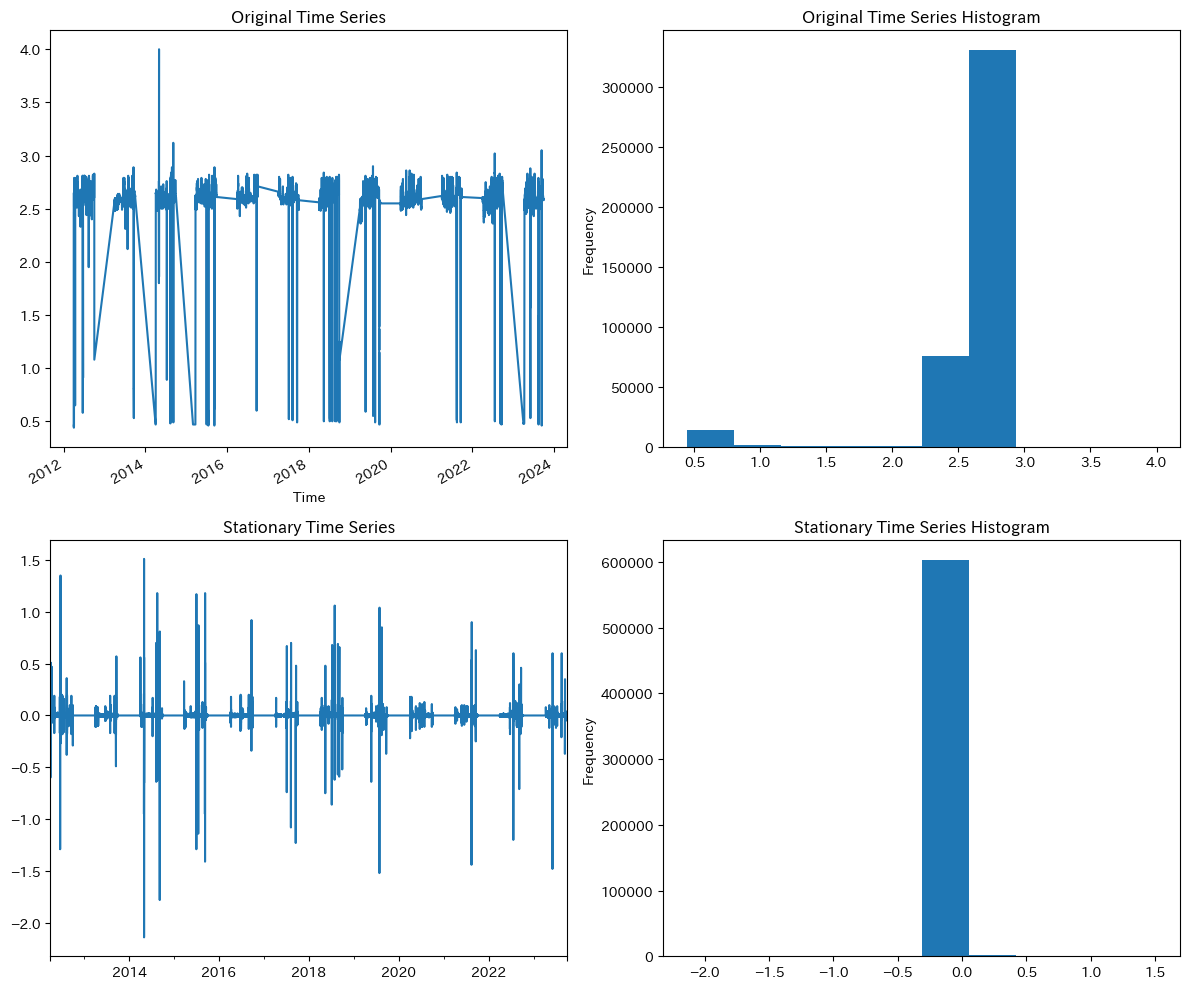

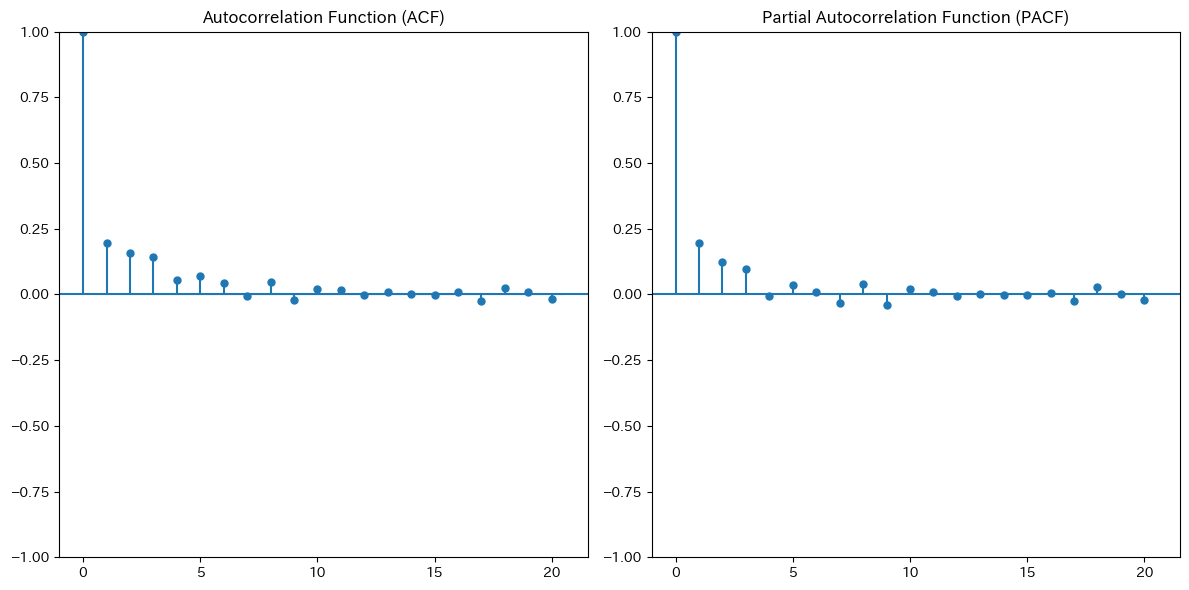

         lb_stat  lb_pvalue
20  59896.178547        0.0
The time series is not white noise
Using Kolmogorov-Smirnov test
Statistic: 0.464662
p-value: 0.000000
The data is not normally distributed
Mean: 3.521831219959029e-06
Standard Deviation: 0.014075547302107437
ACF:
[ 1.96411998e-01  1.57702085e-01  1.43641271e-01  5.34688229e-02
  7.04384030e-02  4.23209912e-02 -6.84520541e-03  4.88831346e-02
 -2.08340338e-02  1.91285175e-02  1.80556824e-02 -3.68749169e-03
  9.48690804e-03  2.47289630e-04 -3.66725237e-03  1.05144264e-02
 -2.42212330e-02  2.34487985e-02  7.59719629e-03 -1.89164744e-02
 -1.28093839e-03 -5.68675535e-03 -4.22599313e-03  1.85393065e-03
 -2.45312030e-02  8.02105521e-03 -1.05648489e-02 -8.00522225e-03
  2.13765514e-03 -7.59958088e-03  2.04457685e-04  1.04632049e-02
 -5.92287232e-03  9.20121061e-04 -1.96528916e-03 -1.27303789e-04
  2.73526103e-03 -2.27920105e-03 -5.06829626e-03 -2.51324679e-04
  2.39009087e-03  2.35838753e-04 -4.60626666e-03  2.81259970e-03
 -7.85710184e-0

In [13]:
analyzer = TimeSeriesAnalyzer(df, 'Time', '別所頭首工 河川水位')
analyzer.run_analysis(fill_method='time', differencing_order=1, lags=20)
